# Training Notebook

In [46]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from MPCNet.dataset import dataset
from MPCNet.controller import utils
from MPCNet.simulation import simulation
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]

In [2]:
X_raw,y = dataset.Dataset.load('data/data5-1000000.csv')

In [4]:
#scaler = preprocessing.StandardScaler().fit(X_raw)
#X = scaler.transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=42)

In [36]:
normalizationLayer = tf.keras.layers.Normalization(axis=-1, input_dim=5)
normalizationLayer.adapt(X_train)

In [65]:
batch_size, lr, num_epochs = 5000, 0.001, 300
loss = tf.keras.losses.MeanSquaredError()
trainer = tf.keras.optimizers.Adam(learning_rate=lr)

In [66]:
net = tf.keras.models.Sequential([
    normalizationLayer,
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])
net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_39 (Dense)            (None, 64)                384       
                                                                 
 dense_40 (Dense)            (None, 128)               8320      
                                                                 
 dense_41 (Dense)            (None, 128)               16512     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 64)                4160      
                                                      

In [67]:
net.compile(trainer, loss)
net.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    use_multiprocessing=True)

Epoch 1/300
144/144 [==============================] - 1s 8ms/step - loss: 0.2349 - val_loss: 0.1365
Epoch 2/300
144/144 [==============================] - 1s 8ms/step - loss: 0.1257 - val_loss: 0.1190
Epoch 3/300
144/144 [==============================] - 1s 7ms/step - loss: 0.1145 - val_loss: 0.1103
Epoch 4/300
144/144 [==============================] - 1s 8ms/step - loss: 0.1094 - val_loss: 0.1063
Epoch 5/300
144/144 [==============================] - 1s 8ms/step - loss: 0.1059 - val_loss: 0.1059
Epoch 6/300
144/144 [==============================] - 1s 7ms/step - loss: 0.1038 - val_loss: 0.1012
Epoch 7/300
144/144 [==============================] - 1s 8ms/step - loss: 0.1014 - val_loss: 0.0989
Epoch 8/300
144/144 [==============================] - 1s 7ms/step - loss: 0.0995 - val_loss: 0.1012
Epoch 9/300
144/144 [==============================] - 1s 8ms/step - loss: 0.0981 - val_loss: 0.0959
Epoch 10/300
144/144 [==============================] - 1s 7ms/step - loss: 0.0961 - val_lo

In [56]:
net.evaluate(x=X_test, y=y_test)

6250/6250 [==============================] - 8s 1ms/step - loss: 0.0750


0.07501960545778275

In [57]:
net.save('model-temp.hdf5')

In [58]:
loaded_model = tf.keras.models.load_model('model-temp.hdf5')
def nnController(initialState, finalState):
    relativeInitial, relativeFinal = utils.absoluteToRelative(initialState, finalState)
    inputVector = tf.constant([
        relativeInitial[0],
        relativeFinal[0],
        relativeFinal[1],
        relativeFinal[2],
        relativeFinal[3]
    ], shape=(1,5))
    #normalizedInput = scaler.transform(inputVector)
    predictedControl = loaded_model.predict(inputVector)
    return np.array([predictedControl[0][0], predictedControl[0][1]], dtype=np.double)

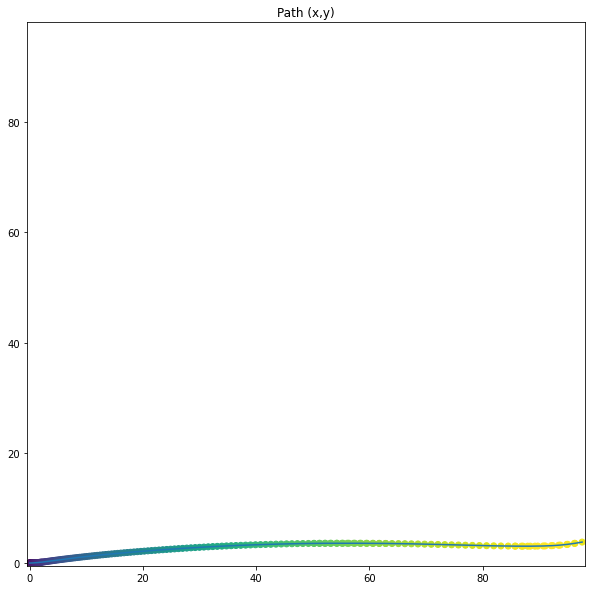

In [63]:
initialState = np.array([0, 0, 0, 0], dtype=np.double)
targetState = np.array([100, 0, 0, np.pi/4], dtype=np.double)

sim = simulation.Simulation(
    initialState,
    targetState,
    10.0,
    nnController,
    stopRadius=5.0)

sim.runSimulation(30.0, quiet=True)
simulation.plot_path(sim, fileName="model-example.png")